In [1]:
# Import the required modules
import numpy as np                # scientific library
import pandas as pd

import matplotlib.pyplot as plt   # for creating plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # improve resolution

from scipy.integrate import odeint # numerical solver of odes

In [2]:
# Define the ODE. (omega12=0.5omega2)
def vac(y,t,mu, p, theta, omega1, omega2, gamma, beta, sigma, epsilon, m1, m2, N):
    S1,S2,I,V,R,M = y # specify variables
    m=m1*((S1+S2)/N+m2*(1-epsilon)*V/N)/((S1+S2)/N+(1-epsilon)*V/N) #1-phi in the original model
    omega12=0.5*omega2
    o=omega1*((S1+S2)/N+(omega12/omega1)*(1-epsilon)*V/N)/((S1+S2)/N+(1-epsilon)*V/N) 
    pie=mu*N+m*sigma*I
    
    dydt= np.empty(len(y)) # create empty vector and then fill entries with the corresponding RHS
    dydt[0]= (1-p)*(1-theta)*pie-mu*S1-beta*I*S1/N+o*R*(1-theta) #dS1dt
    dydt[1]=(1-p)*theta*pie-mu*S2-beta*I*S2/N+omega2*V-gamma*S2+o*R*theta#dS2dt
    dydt[2]=beta*I*S1/N+beta*I*S2/N -mu*I +beta*I*V*(1-epsilon)/N-sigma*I #dIdt
    dydt[3]= gamma*S2-omega2*V-mu*V-beta*I*V*(1-epsilon)/N + p*pie #dVdt
    dydt[4]= (1-m)*sigma*I-R*(mu+o) #dRdt
    dydt[5]= m*sigma*I #dMdt
    return dydt # the function will return the value of the ODE RHS


In [3]:
# Define the ODE.  (omega12=omega2)
def vac1(y,t,mu, p, theta, omega1, omega2, gamma, beta, sigma, epsilon, m1, m2, N):
    
    # Define ODE
    S1,S2,I,V,R,M = y # specify variables
    m=m1*((S1+S2)/N+m2*(1-epsilon)*V/N)/((S1+S2)/N+(1-epsilon)*V/N) #1-phi in the original model
    omega12=omega2
    o=omega1*((S1+S2)/N+(omega12/omega1)*(1-epsilon)*V/N)/((S1+S2)/N+(1-epsilon)*V/N) 
    #o=omega1
    pie=mu*N+m*sigma*I
    
    dydt= np.empty(len(y)) # create empty vector and then fill entries with the corresponding RHS
    dydt[0]= (1-p)*(1-theta)*pie-mu*S1-beta*I*S1/N+o*R*(1-theta) #dS1dt
    dydt[1]=(1-p)*theta*pie-mu*S2-beta*I*S2/N+omega2*V-gamma*S2+o*R*theta#dS2dt
    dydt[2]=beta*I*S1/N+beta*I*S2/N -mu*I +beta*I*V*(1-epsilon)/N-sigma*I #dIdt
    dydt[3]= gamma*S2-omega2*V-mu*V-beta*I*V*(1-epsilon)/N + p*pie #dVdt
    dydt[4]= (1-m)*sigma*I-R*(mu+o) #dRdt
    dydt[5]= m*sigma*I #dMdt
    return dydt # the function will return the value of the ODE RHS


In [4]:
# Use this function to get Re from the ODE solution (using Eq. 3.7)
def get_Re(sol, R0, epsilon, N):
    S1=sol[:,0]
    S2=sol[:,1]
    V=sol[:,3]
    return R0*(S1+S2+(1-epsilon)*V)/N

# Use this function to get the death rate (dm/dt)
def get_dm(sol):
    result=[]
    for i in range(1,len(sol[:,-1])):
        result.append(sol[:,-1][i]-sol[:,-1][i-1])
    result=np.array(result)
    return result


In [5]:
# Use this function to get the di/dt
def get_di(sol):
    result=[0]
    for i in range(1,len(sol[:,2])):
        result.append(sol[:,2][i]-sol[:,2][i-1])
    result=np.array(result)
    return result

# Get the time for i peaks
def get_i_peak(sol,n=3000):
    di=get_di(sol)
    result=[]
    for i in range(1, n):
        if (di[i]*di[i+1]<0) and (di[i]>0):
            result.append(i)
    return np.array(result)

# Use Eq. 3.14 to find out the equilibrium death rate
def check_death(sol, epsilon=0.8,R0=4,m1=0.01,m2=0.1, sigma=1/14):
    i=sol[:,2][-1]/N
    v=sol[:,3][-1]/N
    return sigma*i*m1*(1-R0*(1-epsilon)*(1-m2)*v)

# R0=4

In [6]:
# Set the unchanged parameters
N=67000000 
T=365*12
t1=np.arange(0,T,1)

p=0
mu=0
sigma=1/14 #Take 14 days for people recovered
epsilon=0.8# Assume the effectiveness of the vaccine is 80%
m1=0.01 #infected modality rate
m2=0.1 #inefficacy of vaccine against modality
R0=4
beta=R0*(mu+sigma)

In [7]:
# Set the initial condition
I=1/65*N
R=0.2*N-133437
M=0.002*N
V=43.2*10**6
S2=0
S1=0.147*N
y0=np.array([0.15,0,0.015,0.64,0.195,0.00179])*N

In [8]:
# Set those changing parameters
theta_1=0.65
theta_2=0.8
theta_3=0.95

omega_1=1/365
omega_2=1/180
omega_3=1/770
omega_4=1/1540

gamma_3=1/180
gamma_2=1/90
gamma_1=1/30

In [9]:
# Change theta
sol_111 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111=get_Re(sol_111, R0, epsilon, N)
sol_211 = odeint(vac, y0, t1, args=(mu, p, theta_2, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_211=get_Re(sol_211, R0, epsilon, N)
sol_311 = odeint(vac, y0, t1, args=(mu, p, theta_3, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_311=get_Re(sol_311, R0, epsilon, N)

# Change omega, fraction =0.5
#o1=1/180, o2=1/180
sol_1221 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221=get_Re(sol_1221, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211=get_Re(sol_1211, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231=get_Re(sol_1231, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131=get_Re(sol_1131, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331=get_Re(sol_1131, R0, epsilon, N)


# Only change omega2, fraction =1
sol_111_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111_d=get_Re(sol_111_d, R0, epsilon, N)
#o1=1/180, o2=1/180
sol_1221_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221_d=get_Re(sol_1221_d, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211_d=get_Re(sol_1211_d, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231_d=get_Re(sol_1231_d, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131_d=get_Re(sol_1131_d, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331_d=get_Re(sol_1131_d, R0, epsilon, N)

# Change gamma
sol_112 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_2, beta, sigma, epsilon, m1, m2, N))
Re_112=get_Re(sol_112, R0, epsilon, N)
sol_113 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_3, beta, sigma, epsilon, m1, m2, N))
Re_113=get_Re(sol_113, R0, epsilon, N)

In [10]:
# Change epsilon
sol_111_1 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, 0.9, m1, m2, N))
Re_111_1=get_Re(sol_111_1, R0, 0.9, N)
dm_111_1=get_dm(sol_111_1)

sol_111_2 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, 0.65, m1, m2, N))
Re_111_2=get_Re(sol_111_2, R0, 0.65, N)
dm_111_2=get_dm(sol_111_2)

sol_111_3 = odeint(vac, y0, t1, args=(mu, p, 0, omega_1, omega_1, gamma_1, beta, sigma, 0, m1, m2, N))
Re_111_3=get_Re(sol_111_3, R0, 0, N)
dm_111_3=get_dm(sol_111_3)

In [11]:
# Change Rc
beta_4=3*(mu+sigma)
sol_111_4 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta_4, sigma, 0.8, m1, m2, N))
Re_111_4=get_Re(sol_111_4, 3, 0.8, N)
dm_111_4=get_dm(sol_111_4)

beta_5=1.5*(mu+sigma)
sol_111_5 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta_5, sigma, 0.8, m1, m2, N))
Re_111_5=get_Re(sol_111_5, 1.5, 0.8, N)
dm_111_5=get_dm(sol_111_5)


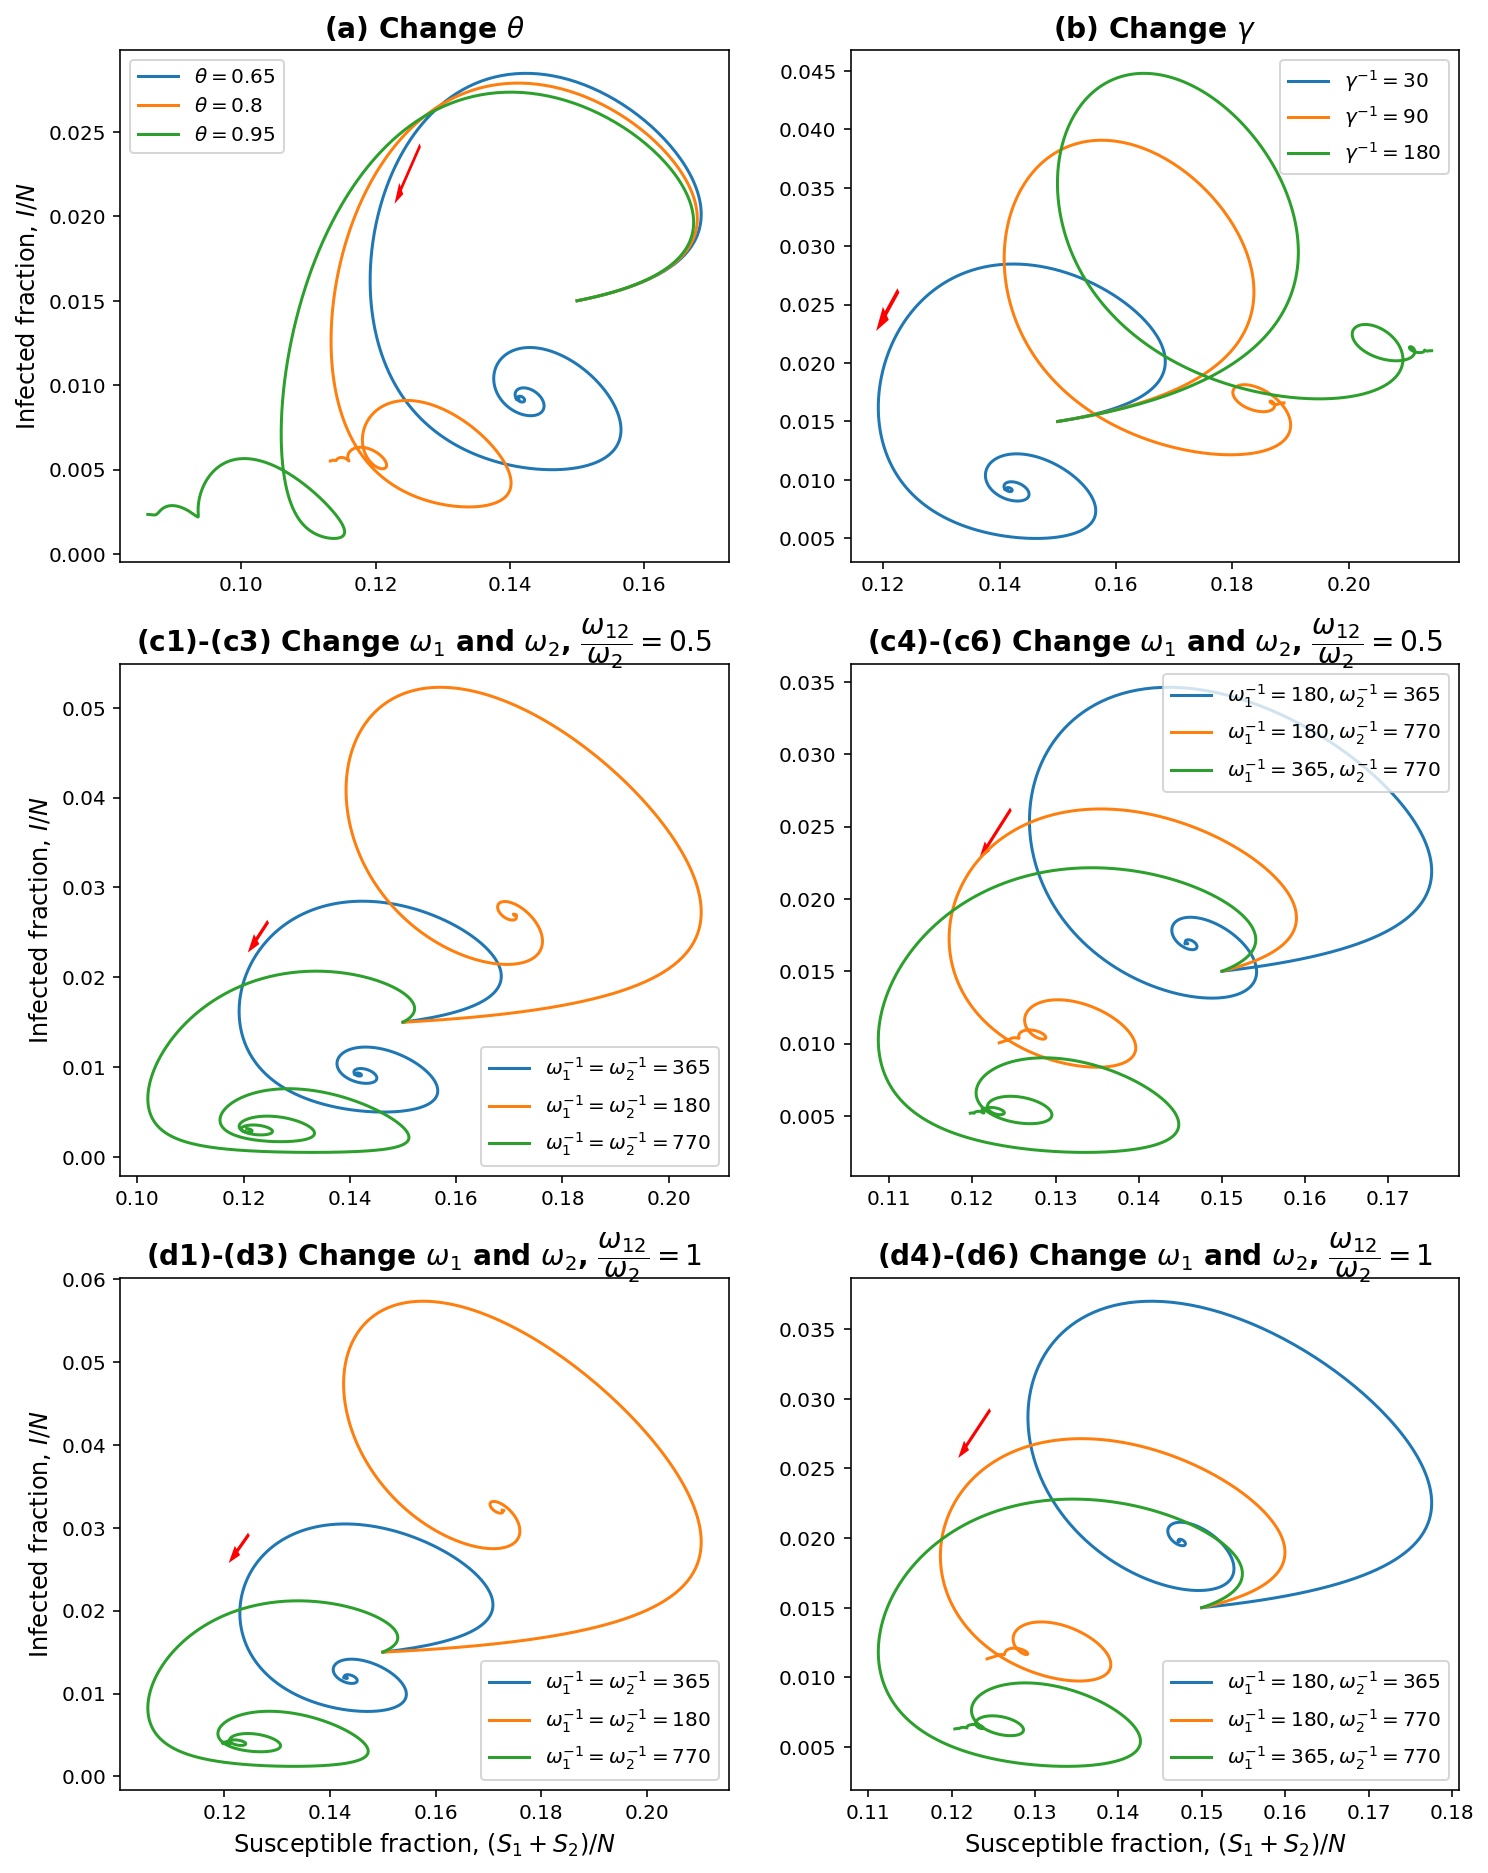

In [12]:
# Get the phase plot
fig, axes = plt.subplots(3,2,figsize=(12, 16))
axes[0, 0].plot((sol_111[:,0]+sol_111[:,1])/N, sol_111[:,2]/N, label=r"$\theta=0.65$")
axes[0, 0].plot((sol_211[:,0]+sol_211[:,1])/N, sol_211[:,2]/N, label=r"$\theta=0.8$")
axes[0, 0].plot((sol_311[:,0]+sol_311[:,1])/N, sol_311[:,2]/N, label=r"$\theta=0.95$")
axes[0, 0].set_ylabel(r"Infected fraction, $I/N$", fontsize=12)
axes[0, 0].set_title(r"(a) Change $\theta$", fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].plot((sol_111[:,0]+sol_111[:,1])/N, sol_111[:,2]/N, label=r"$\gamma^{-1}=30$")
axes[0, 1].plot((sol_112[:,0]+sol_112[:,1])/N, sol_112[:,2]/N, label=r"$\gamma^{-1}=90$")
axes[0, 1].plot((sol_113[:,0]+sol_113[:,1])/N, sol_113[:,2]/N, label=r"$\gamma^{-1}=180$")
axes[0, 1].set_title(r"(b) Change $\gamma$", fontsize=14, fontweight='bold')
axes[0, 1].legend()

axes[1, 0].plot((sol_111[:,0]+sol_111[:,1])/N, sol_111[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[1, 0].plot((sol_1221[:,0]+sol_1221[:,1])/N, sol_1221[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[1, 0].plot((sol_1331[:,0]+sol_1331[:,1])/N, sol_1331[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
axes[1, 0].set_ylabel(r"Infected fraction, $I/N$", fontsize=12)
axes[1, 0].set_title(r"(c1)-(c3) Change $\omega_{1}$ and $\omega_{2}$, $ \dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=14, fontweight='bold')
axes[1, 0].legend()


axes[1, 1].plot((sol_1211[:,0]+sol_1211[:,1])/N, sol_1211[:,2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[1, 1].plot((sol_1231[:,0]+sol_1231[:,1])/N, sol_1231[:,2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[1, 1].plot((sol_1131[:,0]+sol_1131[:,1])/N, sol_1131[:,2]/N, label=r"$\omega_{1}^{-1}=365, \omega_{2}^{-1}=770$")
axes[1, 1].set_title(r"(c4)-(c6) Change $\omega_{1}$ and $\omega_{2}$, $\dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=14, fontweight='bold')
axes[1, 1].legend()

axes[2, 0].plot((sol_111_d[:,0]+sol_111_d[:,1])/N, sol_111_d[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[2, 0].plot((sol_1221_d[:,0]+sol_1221_d[:,1])/N, sol_1221_d[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[2, 0].plot((sol_1331_d[:,0]+sol_1331_d[:,1])/N, sol_1331_d[:,2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
axes[2, 0].set_ylabel(r"Infected fraction, $I/N$", fontsize=12)
axes[2, 0].set_xlabel(r"Susceptible fraction, $(S_{1}+S_{2})/N$", fontsize=12)
axes[2, 0].set_title(r"(d1)-(d3) Change $\omega_{1}$ and $\omega_{2}$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=14, fontweight='bold')
axes[2, 0].legend()

axes[2, 1].plot((sol_1211_d[:,0]+sol_1211_d[:,1])/N, sol_1211_d[:,2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[2, 1].plot((sol_1231_d[:,0]+sol_1231_d[:,1])/N, sol_1231_d[:,2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[2, 1].plot((sol_1131_d[:,0]+sol_1131_d[:,1])/N, sol_1131_d[:,2]/N, label=r"$\omega_{1}^{-1}=365, \omega_{2}^{-1}=770$")
axes[2, 1].set_xlabel(r"Susceptible fraction, $(S_{1}+S_{2})/N$", fontsize=12)
axes[2, 1].set_title(r"(d4)-(d6) Change $\omega_{1}$ and $\omega_{2}$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=14, fontweight='bold')
axes[2, 1].legend()

x_s1=(sol_111[:,0][130]+sol_111[:,1][130])/N
x_e1=(sol_111[:,0][150]+sol_111[:,1][150])/N
y_s1=sol_111[:,2][130]/N
y_e1=sol_111[:,2][150]/N
axes[0,0].arrow(x_s1+0.002, y_s1, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0003)
axes[0,1].arrow(x_s1-0.002, y_s1+0.002, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0005)
axes[1,0].arrow(x_s1, y_s1+0.002, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0005)
axes[1,1].arrow(x_s1, y_s1+0.002, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0003)
axes[2,0].arrow(x_s1, y_s1+0.005, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0005)
axes[2,1].arrow(x_s1, y_s1+0.005, x_e1-x_s1, y_e1-y_s1, color="red",shape='full', lw=0, length_includes_head=True, width=0.0003)

#fig.suptitle('Phase diagrams for different parameters', fontsize=16, fontweight='bold')
plt.show()

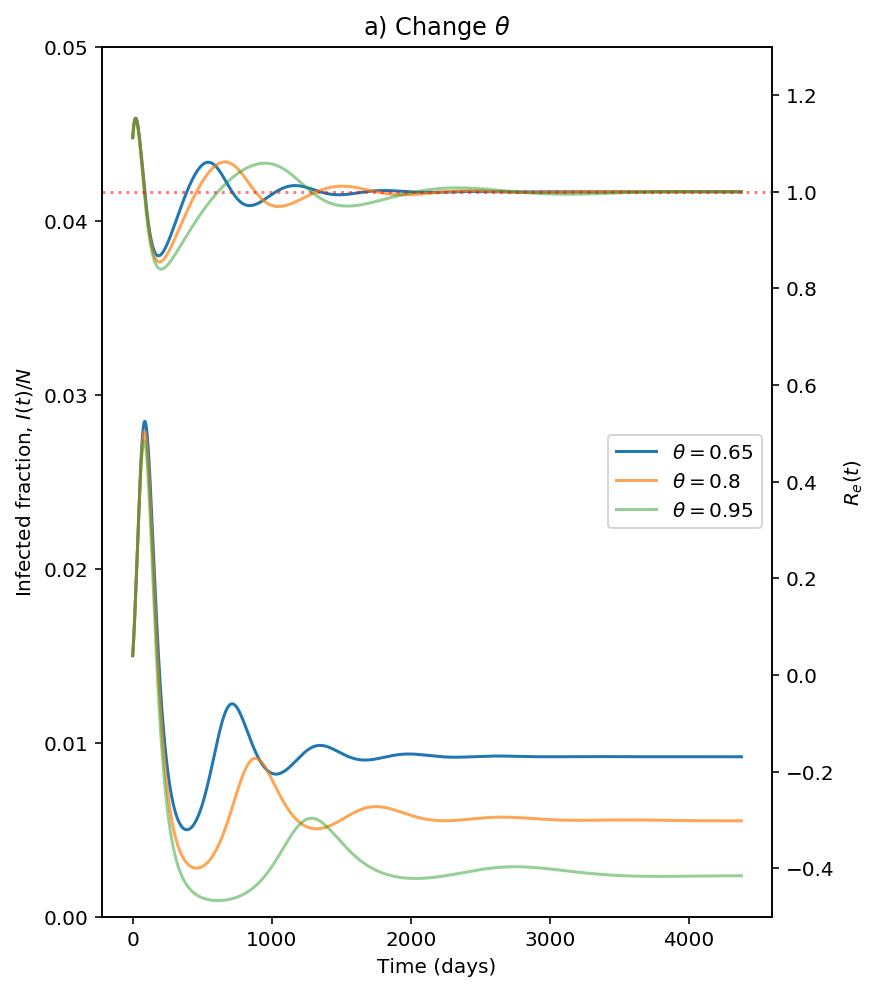

In [13]:
# Change Theta
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_111[:, 2]/N, label=r"$\theta=0.65$")
ax.plot(t1, sol_211[:, 2]/N,alpha=0.7, label=r"$\theta=0.8$")
ax.plot(t1, sol_311[:, 2]/N,alpha=0.5, label=r"$\theta=0.95$")
ax.set_ylim([0,0.05])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_111)
ax2.plot(t1, Re_211, alpha=0.7)
ax2.plot(t1, Re_311, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([-0.5,1.3])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"a) Change $\theta$")

plt.show()


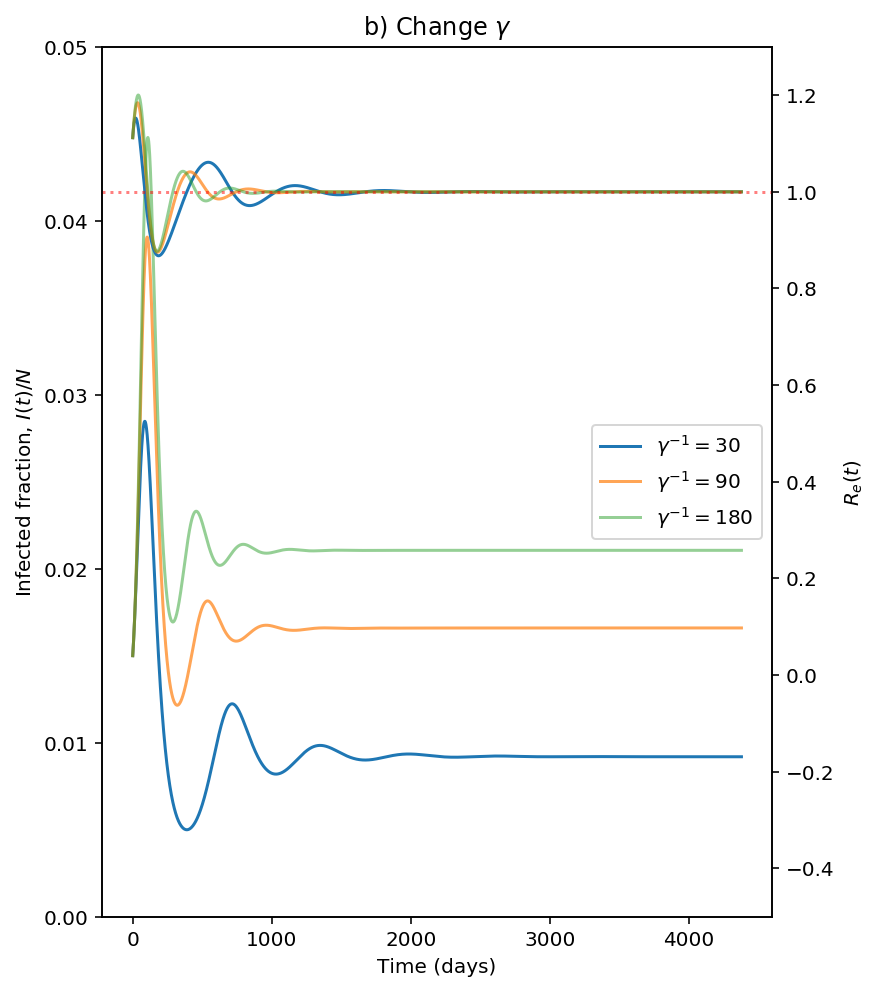

In [14]:
### Change gamma
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_111[:, 2]/N, label=r"$\gamma^{-1}=30$")
ax.plot(t1, sol_112[:, 2]/N,alpha=0.7, label=r"$\gamma^{-1}=90$")
ax.plot(t1, sol_113[:, 2]/N,alpha=0.5, label=r"$\gamma^{-1}=180$")
ax.set_ylim([0,0.05])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_111)
ax2.plot(t1, Re_112, alpha=0.7)
ax2.plot(t1, Re_113, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([-0.5,1.3])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"b) Change $\gamma$ ")

plt.show()


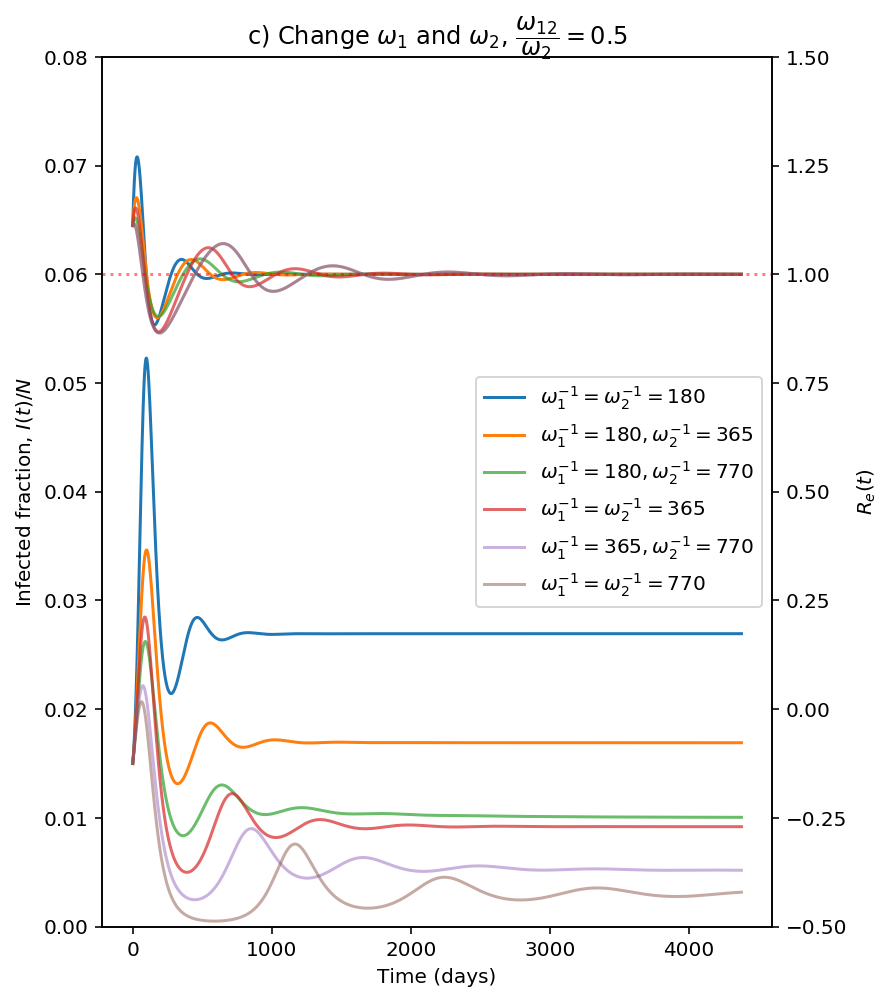

In [15]:
# Change Omega
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_1221[:, 2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
ax.plot(t1, sol_1211[:, 2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
ax.plot(t1, sol_1231[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
ax.plot(t1, sol_111[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
ax.plot(t1, sol_1131[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
ax.plot(t1, sol_1331[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
ax.set_ylim([0,0.08])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_1221)
ax2.plot(t1, Re_1211)
ax2.plot(t1, Re_1231, alpha=0.7)
ax2.plot(t1, Re_111, alpha=0.7)
ax2.plot(t1, Re_1131, alpha=0.5)
ax2.plot(t1, Re_1331, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([-0.5,1.5])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"c) Change $\omega_{1}$ and $\omega_{2}$, $\dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=12)

plt.show()


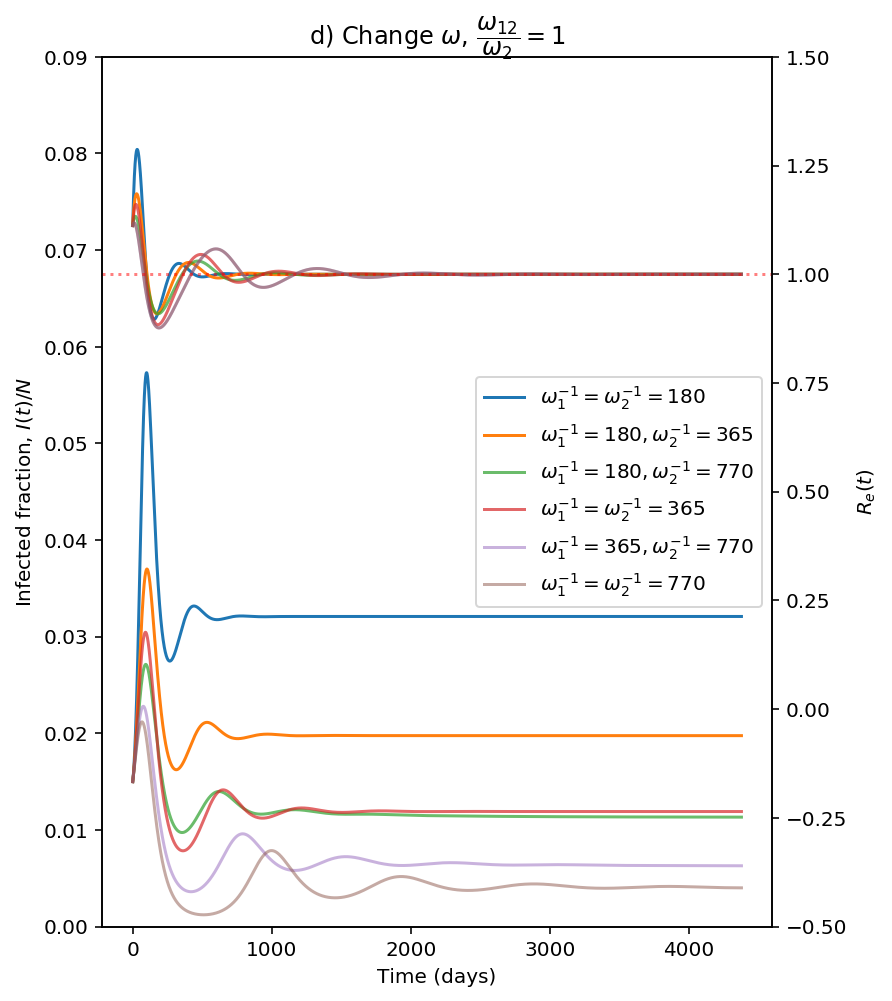

In [16]:
# Change Omega, ratio=1
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_1221_d[:, 2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
ax.plot(t1, sol_1211_d[:, 2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
ax.plot(t1, sol_1231_d[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
ax.plot(t1, sol_111_d[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
ax.plot(t1, sol_1131_d[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
ax.plot(t1, sol_1331_d[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
ax.set_ylim([0,0.09])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_1221_d)
ax2.plot(t1, Re_1211_d)
ax2.plot(t1, Re_1231_d, alpha=0.7)
ax2.plot(t1, Re_111_d, alpha=0.7)
ax2.plot(t1, Re_1131_d, alpha=0.5)
ax2.plot(t1, Re_1331_d, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([-0.5,1.5])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"d) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=12)

plt.show()


In [17]:
# Get the death rate
dm_111=get_dm(sol_111)
dm_111_d=get_dm(sol_111_d)
dm_211=get_dm(sol_211)
dm_311=get_dm(sol_311)
dm_1221=get_dm(sol_1221)
dm_1211=get_dm(sol_1211)
dm_1231=get_dm(sol_1231)
dm_1131=get_dm(sol_1131)
dm_1331=get_dm(sol_1331)

dm_1221_d=get_dm(sol_1221_d)
dm_1211_d=get_dm(sol_1211_d)
dm_1231_d=get_dm(sol_1231_d)
dm_1131_d=get_dm(sol_1131_d)
dm_1331_d=get_dm(sol_1331_d)
dm_112=get_dm(sol_112)
dm_113=get_dm(sol_113)

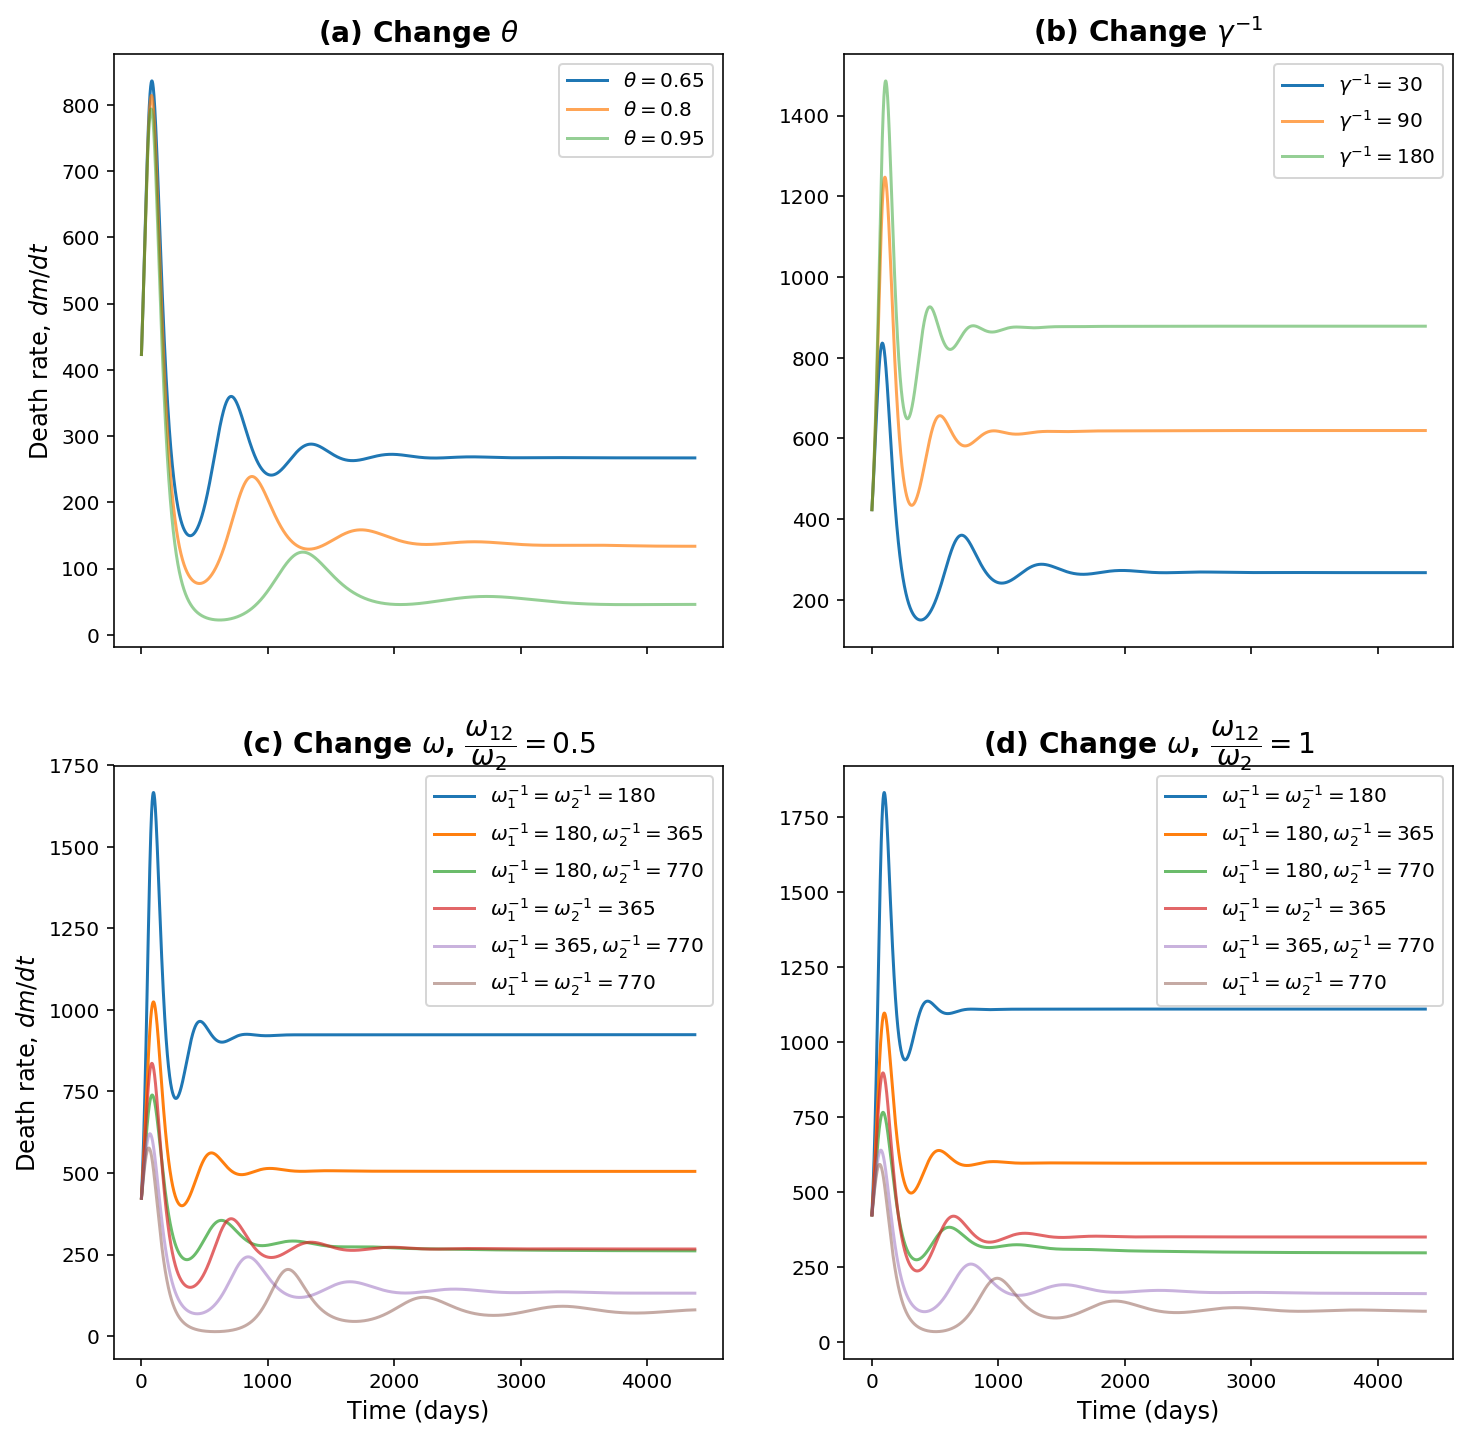

In [18]:
# Get the plot for death rate
fig, axes = plt.subplots(2, 2,figsize=(12, 12),
                       sharex='col')
axes[0, 0].plot(dm_111, label=r"$\theta=0.65$")
axes[0, 0].plot(dm_211, alpha=0.7, label=r"$\theta=0.8$")
axes[0, 0].plot(dm_311, alpha=0.5, label=r"$\theta=0.95$")
axes[0, 0].set_ylabel(r"Death rate, $dm/dt$", fontsize=12)
axes[0, 0].set_title(r"(a) Change $\theta$", fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].plot(dm_111, label=r"$\gamma^{-1}=30$")
axes[0, 1].plot(dm_112,  alpha=0.7,label=r"$\gamma^{-1}=90$")
axes[0, 1].plot(dm_113,  alpha=0.5,label=r"$\gamma^{-1}=180$")
axes[0, 1].set_title(r"(b) Change $\gamma^{-1}$", fontsize=14, fontweight='bold')
axes[0, 1].legend()


axes[1, 0].plot(dm_1221, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[1, 0].plot(dm_1211, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[1, 0].plot(dm_1231,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[1, 0].plot(dm_111,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[1, 0].plot(dm_1131,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
axes[1, 0].plot(dm_1331,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
axes[1, 0].set_ylabel(r"Death rate, $dm/dt$", fontsize=12)
axes[1, 0].set_xlabel("Time (days)", fontsize=12)
axes[1, 0].set_title(r"(c) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=14, fontweight='bold')
axes[1, 0].legend()


axes[1, 1].plot(dm_1221_d, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[1, 1].plot(dm_1211_d, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[1, 1].plot(dm_1231_d, alpha=0.7,label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[1, 1].plot(dm_111_d, alpha=0.7,label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[1, 1].plot(dm_1131_d,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
axes[1, 1].plot(dm_1331_d,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")

axes[1, 1].set_xlabel("Time (days)", fontsize=12)
axes[1, 1].set_title(r"(d) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=14, fontweight='bold')
axes[1, 1].legend()

#fig.suptitle('Death rate for different parameters', fontsize=16, fontweight='bold')
plt.show()

In [19]:
# Get Table 3
clust_data =  [["(0.65, 365,30)",sol_111[:,0][-1]/N, sol_111[:,1][-1]/N, sol_111[:,2][-1]/N,  sol_111[:,3][-1]/N, check_death(sol_111),dm_111[-1]/N,dm_111[-1], Re_111[-1]],
["(0.8, 365,30)",sol_211[:,0][-1]/N, sol_211[:,1][-1]/N, sol_211[:,2][-1]/N,  sol_211[:,3][-1]/N,  check_death(sol_211),dm_211[-1]/N,dm_211[-1],Re_211[-1]],
["(0.95, 365,30)",sol_311[:,0][-1]/N, sol_311[:,1][-1]/N, sol_311[:,2][-1]/N,  sol_311[:,3][-1]/N,check_death(sol_311),dm_311[-1]/N,dm_311[-1],Re_311[-1]],
["(0.65, 365,90)",sol_112[:,0][-1]/N, sol_112[:,1][-1]/N, sol_112[:,2][-1]/N,  sol_112[:,3][-1]/N, check_death(sol_112),dm_112[-1]/N,dm_112[-1], Re_112[-1]],
["(0.65, 365,180)",sol_113[:,0][-1]/N, sol_113[:,1][-1]/N, sol_113[:,2][-1]/N,  sol_113[:,3][-1]/N,check_death(sol_113),dm_113[-1]/N,dm_113[-1],Re_113[-1]],
["(0.65, 180,180,30)",sol_1221[:,0][-1]/N,sol_1221[:,1][-1]/N, sol_1221[:,2][-1]/N,  sol_1221[:,3][-1]/N, check_death(sol_1221),dm_1221[-1]/N,dm_1221[-1],Re_1221[-1]],
["(0.65, 770,770,30)",sol_1331[:,0][-1]/N, sol_1331[:,1][-1]/N, sol_1331[:,2][-1]/N,  sol_1331[:,3][-1]/N,check_death(sol_1331),dm_1331[-1]/N,dm_1331[-1],Re_1331[-1]],
["(0.65, 180,365,30)",sol_1211[:,0][-1]/N,sol_1211[:,1][-1]/N, sol_1211[:,2][-1]/N,  sol_1211[:,3][-1]/N, check_death(sol_1211),dm_1211[-1]/N,dm_1211[-1],Re_1211[-1]],
["(0.65, 180,770,30)",sol_1231[:,0][-1]/N,sol_1231[:,1][-1]/N, sol_1231[:,2][-1]/N,  sol_1231[:,3][-1]/N, check_death(sol_1231),dm_1231[-1]/N,dm_1231[-1],Re_1231[-1]], 
["(0.65, 365,770,30)",sol_1131[:,0][-1]/N,sol_1131[:,1][-1]/N, sol_1131[:,2][-1]/N,  sol_1131[:,3][-1]/N, check_death(sol_1131),dm_1131[-1]/N,dm_1131[-1],Re_1131[-1]],        
["d(0.65, 365,365,30)",sol_111_d[:,0][-1]/N,sol_111_d[:,1][-1]/N, sol_111_d[:,2][-1]/N,  sol_111_d[:,3][-1]/N, check_death(sol_111_d),dm_111_d[-1]/N,dm_111_d[-1],Re_111_d[-1]],
["d(0.65, 180,180,30)",sol_1221_d[:,0][-1]/N,sol_1221_d[:,1][-1]/N, sol_1221_d[:,2][-1]/N,  sol_1221_d[:,3][-1]/N, check_death(sol_1221_d),dm_1221_d[-1]/N,dm_1221_d[-1],Re_1221_d[-1]],
["d(0.65, 770,770,30)",sol_1331_d[:,0][-1]/N, sol_1331_d[:,1][-1]/N, sol_1331_d[:,2][-1]/N,  sol_1331_d[:,3][-1]/N,check_death(sol_1331_d),dm_1331_d[-1]/N,dm_1331_d[-1],Re_1331_d[-1]],
["d(0.65, 180,365,30)",sol_1211_d[:,0][-1]/N,sol_1211_d[:,1][-1]/N, sol_1211_d[:,2][-1]/N,  sol_1211_d[:,3][-1]/N, check_death(sol_1211_d),dm_1211_d[-1]/N,dm_1211_d[-1],Re_1211_d[-1]],
["d(0.65, 180,770,30)",sol_1231_d[:,0][-1]/N,sol_1231_d[:,1][-1]/N, sol_1231_d[:,2][-1]/N,  sol_1231_d[:,3][-1]/N, check_death(sol_1231_d),dm_1231_d[-1]/N,dm_1231_d[-1],Re_1231_d[-1]], 
["d(0.65, 365,770,30)",sol_1131_d[:,0][-1]/N,sol_1131_d[:,1][-1]/N, sol_1131_d[:,2][-1]/N,  sol_1131_d[:,3][-1]/N, check_death(sol_1131_d),dm_1131_d[-1]/N,dm_1131_d[-1],Re_1131_d[-1]],        
["ep=0.9",sol_111_1[:,0][-1]/N, sol_111_1[:,1][-1]/N, sol_111_1[:,2][-1]/N,  sol_111_1[:,3][-1]/N, check_death(sol_111_1,0.9),dm_111_1[-1]/N,dm_111_1[-1],Re_111_1[-1]],
["ep=0.65",sol_111_2[:,0][-1]/N, sol_111_2[:,1][-1]/N, sol_111_2[:,2][-1]/N,  sol_111_2[:,3][-1]/N, check_death(sol_111_2,0.65),dm_111_2[-1]/N,dm_111_2[-1],Re_111_1[-1]],
["ep=0",sol_111_3[:,0][-1]/N, sol_111_3[:,1][-1]/N, sol_111_3[:,2][-1]/N,  sol_111_3[:,3][-1]/N, check_death(sol_111_3,0),dm_111_3[-1]/N,dm_111_3[-1],Re_111_3[-1]],
["R0=3",sol_111_4[:,0][-1]/N, sol_111_4[:,1][-1]/N, sol_111_4[:,2][-1]/N,  sol_111_4[:,3][-1]/N, check_death(sol_111_4,0.8,4),dm_111_4[-1]/N,dm_111_4[-1],Re_111_4[-1]],
["R0=1.5",sol_111_5[:,0][-1]/N, sol_111_5[:,1][-1]/N, sol_111_5[:,2][-1]/N,  sol_111_5[:,3][-1]/N, check_death(sol_111_5,0.8,4),dm_111_5[-1]/N,dm_111_5[-1],Re_111_5[-1]]]


df = pd.DataFrame(clust_data, columns=["Parameters", "S1*/N","S2*/N", "I*/N", "V*/N","check","death_rate/N", "death_rate","Re*"])
df

,Parameters,S1*/N,S2*/N,I*/N,V*/N,check,death_rate/N,death_rate,Re*
0,"(0.65, 365,30)",0.087539,5.341053e-02,9.188898e-03,5.452557e-01,3.986773e-06,3.986777e-06,267.114056,1.000001
1,"(0.8, 365,30)",0.050502,6.272293e-02,5.507102e-03,6.838832e-01,1.996734e-06,1.996746e-06,133.781960,1.000005
2,"(0.95, 365,30)",0.015264,7.078356e-02,2.346446e-03,8.196126e-01,6.869704e-07,6.868597e-07,46.019603,0.999881
3,"(0.65, 365,90)",0.087499,1.014003e-01,1.659379e-02,3.055026e-01,9.245563e-06,9.245563e-06,619.452737,1.000000
4,"(0.65, 365,180)",0.087500,1.267749e-01,2.105578e-02,1.786257e-01,1.310556e-05,1.310556e-05,878.072791,1.000000
5,"(0.65, 180,180,30)",0.087500,8.377941e-02,2.694179e-02,3.936030e-01,1.379046e-05,1.379046e-05,923.960857,1.000000
6,"(0.65, 770,770,30)",0.091789,2.880980e-02,3.160788e-03,6.497925e-01,1.201437e-06,1.203701e-06,80.647982,0.999619
7,"(0.65, 180,365,30)",0.087500,5.805984e-02,1.691168e-02,5.221984e-01,7.537985e-06,7.537985e-06,505.044989,1.000000
8,"(0.65, 180,770,30)",0.087593,3.563312e-02,1.005029e-02,6.338330e-01,3.902673e-06,3.902585e-06,261.473202,0.999971
9,"(0.65, 365,770,30)",0.088519,3.122585e-02,5.181903e-03,6.507994e-01,1.966993e-06,1.966363e-06,131.746333,0.999619


Get Peak day and length of honeymoon period

In [20]:
print(get_i_peak(sol_111))
print(np.diff(get_i_peak(sol_111)))

[  87  715 1348 1986 2624]
[628 633 638 638]


In [21]:
print(get_i_peak(sol_211))
print(np.diff(get_i_peak(sol_211)))

[  85  882 1750 2656]
[797 868 906]


In [22]:
print(get_i_peak(sol_311))
print(np.diff(get_i_peak(sol_311)))

[  83 1286 2752]
[1203 1466]


In [23]:
print(get_i_peak(sol_112))
print(np.diff(get_i_peak(sol_112)))

[ 104  539  960 1381 1810]
[435 421 421 429]


In [24]:
print(get_i_peak(sol_113))
print(np.diff(get_i_peak(sol_113)))

[ 109  457  796 1131 1466 1801 2138 2479 2825 2907]
[348 339 335 335 335 337 341 346  82]


In [25]:
print(get_i_peak(sol_1221))
print(np.diff(get_i_peak(sol_1221)))

[  98  464  830 1199 1584]
[366 366 369 385]


In [26]:
print(get_i_peak(sol_1211))
print(np.diff(get_i_peak(sol_1211)))

[  99  559 1023 1485 1931]
[460 464 462 446]


In [27]:
print(get_i_peak(sol_1231))
print(np.diff(get_i_peak(sol_1231)))

[  91  641 1215 1777]
[550 574 562]


In [28]:
print(get_i_peak(sol_1131))
print(np.diff(get_i_peak(sol_1131)))

[  73  852 1658 2489]
[779 806 831]


In [29]:
print(get_i_peak(sol_1331))
print(np.diff(get_i_peak(sol_1331)))

[  63 1167 2243]
[1104 1076]


In [30]:
print(get_i_peak(sol_111_d))
print(np.diff(get_i_peak(sol_111_d)))

[  92  651 1216 1784 2348 2900]
[559 565 568 564 552]


In [31]:
print(get_i_peak(sol_1221_d))
print(np.diff(get_i_peak(sol_1221_d)))

[ 100  441  781 1126 1502 1554]
[341 340 345 376  52]


In [32]:
print(get_i_peak(sol_1211_d))
print(np.diff(get_i_peak(sol_1211_d)))

[ 103  534  970 1401 1809]
[431 436 431 408]


In [33]:
print(get_i_peak(sol_1231_d))
print(np.diff(get_i_peak(sol_1231_d)))

[  94  621 1165 1674]
[527 544 509]


In [34]:
print(get_i_peak(sol_1131_d))
print(np.diff(get_i_peak(sol_1131_d)))

[  76  791 1533 2292]
[715 742 759]


In [35]:
print(get_i_peak(sol_1331_d))
print(np.diff(get_i_peak(sol_1331_d)))

[  67  999 1931 2887]
[932 932 956]


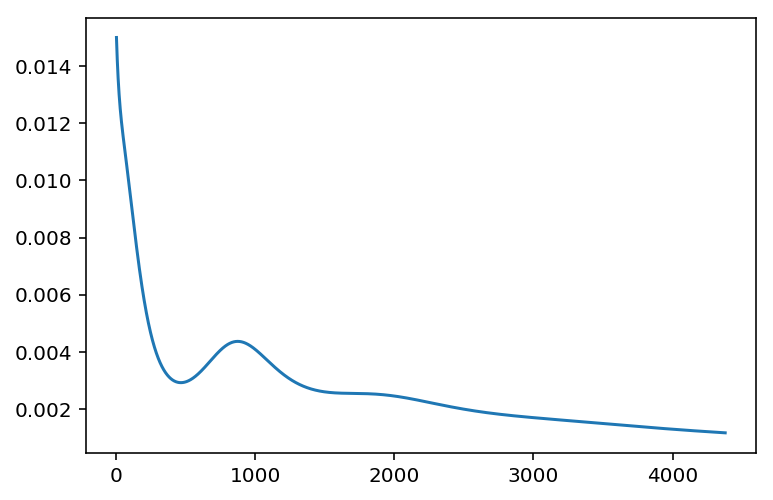

In [43]:
plt.plot(t1, sol_111_1[:, 2]/N)
plt.show()

In [36]:
print(get_i_peak(sol_111_1))
print(np.diff(get_i_peak(sol_111_1)))

[872]
[]


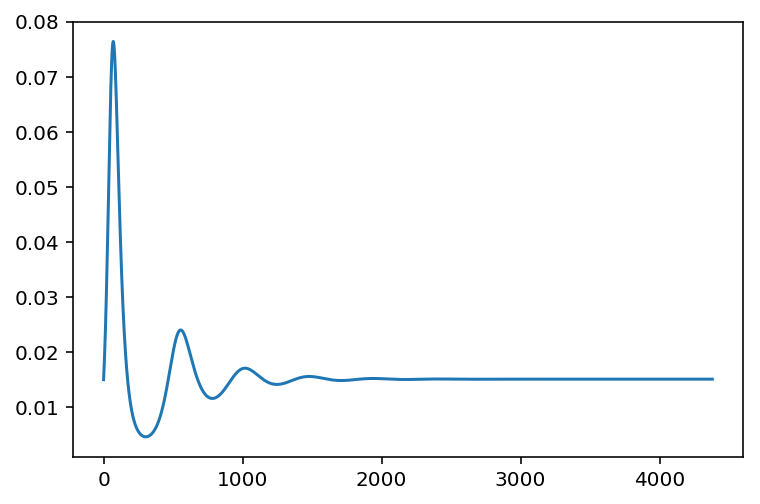

In [45]:
plt.plot(t1, sol_111_2[:, 2]/N)
plt.show()

In [46]:
print(get_i_peak(sol_111_2,2000))
print(np.diff(get_i_peak(sol_111_2,2000)))

[  70  555 1017 1479 1940]
[485 462 462 461]


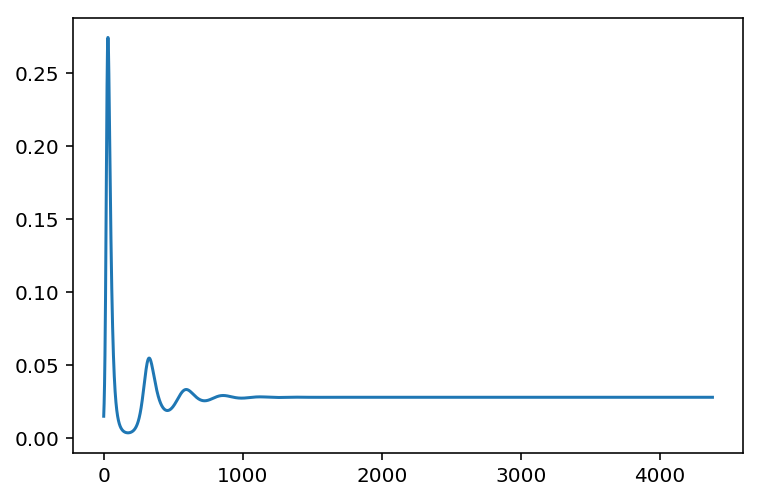

In [47]:
plt.plot(t1, sol_111_3[:, 2]/N)
plt.show()

In [48]:
print(get_i_peak(sol_111_3,1000))
print(np.diff(get_i_peak(sol_111_3,1000)))

[ 30 327 593 859]
[297 266 266]


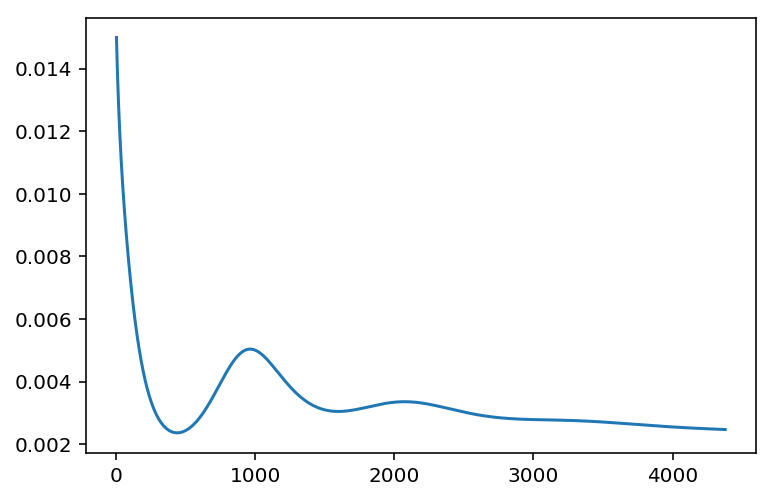

In [50]:
plt.plot(t1, sol_111_4[:, 2]/N)
plt.show()

In [51]:
print(get_i_peak(sol_111_4))
print(np.diff(get_i_peak(sol_111_4)))

[ 962 2072]
[1110]


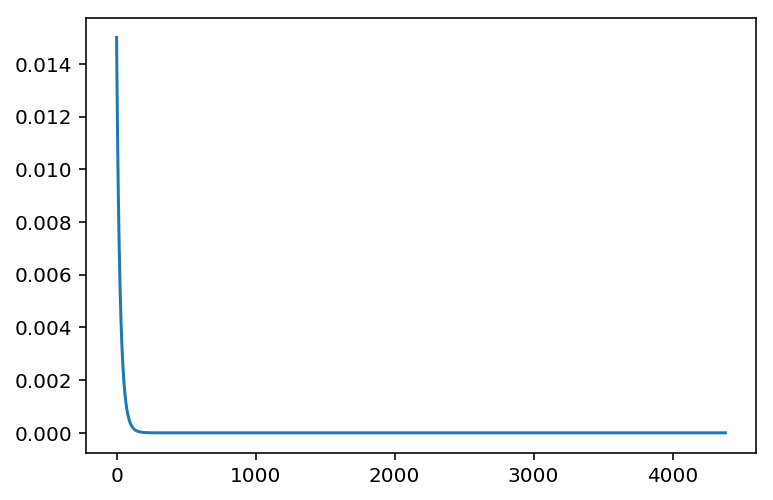

In [53]:
plt.plot(t1, sol_111_5[:, 2]/N)
plt.show()

# No vaccine

In [54]:
# Set the unchanged parameters
N=67000000 
T=365*12
t1=np.arange(0,T,1)

p=0
mu=0
sigma=1/14 #Take 14 days for people recovered
epsilon=0
m1=0.01 #infected modality rate
m2=0.1 #inefficacy of vaccine against modality
R0=4
beta=R0*(mu+sigma)

In [55]:
# Set those changing parameters
theta_1=0
theta_2=0
theta_3=0

omega_1=1/365
omega_2=1/180
omega_3=1/770
omega_4=1/1540

gamma_3=1/180
gamma_2=1/90
gamma_1=1/30

In [56]:
# Change theta
sol_111 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111=get_Re(sol_111, R0, epsilon, N)
sol_211 = odeint(vac, y0, t1, args=(mu, p, theta_2, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_211=get_Re(sol_211, R0, epsilon, N)
sol_311 = odeint(vac, y0, t1, args=(mu, p, theta_3, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_311=get_Re(sol_311, R0, epsilon, N)

# Change omega, fraction =0.5
#o1=1/180, o2=1/180
sol_1221 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221=get_Re(sol_1221, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211=get_Re(sol_1211, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231=get_Re(sol_1231, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131=get_Re(sol_1131, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331=get_Re(sol_1131, R0, epsilon, N)


# Only change omega2, fraction =1
sol_111_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111_d=get_Re(sol_111_d, R0, epsilon, N)
#o1=1/180, o2=1/180
sol_1221_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221_d=get_Re(sol_1221_d, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211_d=get_Re(sol_1211_d, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231_d=get_Re(sol_1231_d, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131_d=get_Re(sol_1131_d, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331_d=get_Re(sol_1131_d, R0, epsilon, N)

# Change gamma
sol_112 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_2, beta, sigma, epsilon, m1, m2, N))
Re_112=get_Re(sol_112, R0, epsilon, N)
sol_113 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_3, beta, sigma, epsilon, m1, m2, N))
Re_113=get_Re(sol_113, R0, epsilon, N)

In [57]:
# Change epsilon
sol_111_1 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, 0.9, m1, m2, N))
Re_111_1=get_Re(sol_111_1, R0, 0.9, N)
dm_111_1=get_dm(sol_111_1)

sol_111_2 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, 0.65, m1, m2, N))
Re_111_2=get_Re(sol_111_2, R0, 0.65, N)
dm_111_2=get_dm(sol_111_2)

sol_111_3 = odeint(vac, y0, t1, args=(mu, p, 0, omega_1, omega_1, gamma_1, beta, sigma, 0, m1, m2, N))
Re_111_3=get_Re(sol_111_3, R0, 0, N)
dm_111_3=get_dm(sol_111_3)

# Change Rc
beta_4=3*(mu+sigma)
sol_111_4 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta_4, sigma, 0.8, m1, m2, N))
Re_111_4=get_Re(sol_111_4, 3, 0.8, N)
dm_111_4=get_dm(sol_111_4)

beta_5=1.5*(mu+sigma)
sol_111_5 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta_5, sigma, 0.8, m1, m2, N))
Re_111_5=get_Re(sol_111_5, 1.5, 0.8, N)
dm_111_5=get_dm(sol_111_5)

In [60]:
dm_no_vac=[get_dm(sol_111)[-1], get_dm(sol_211)[-1],get_dm(sol_311)[-1],
          get_dm(sol_1221)[-1], get_dm(sol_1211)[-1],get_dm(sol_1231)[-1], get_dm(sol_1131)[-1],get_dm(sol_1331)[-1],
          get_dm(sol_1221_d)[-1], get_dm(sol_1211_d)[-1],get_dm(sol_1231_d)[-1], get_dm(sol_1131_d)[-1],get_dm(sol_1331_d)[-1],
          get_dm(sol_112)[-1], get_dm(sol_113)[-1],
          dm_111_1[-1],dm_111_2[-1],dm_111_3[-1],dm_111_4[-1],dm_111_5[-1]]
print(dm_no_vac)

[1338.750498894602, 1338.750498894602, 1338.750498894602, 2614.464099895209, 2614.4640998970717, 2614.464099895209, 1338.7505077691749, 647.356546625495, 2614.4640998989344, 2614.464099895209, 2614.464099895209, 1338.7504974501207, 647.3359155701473, 1338.7504973290488, 1338.7504990007728, 1329.7894901921973, 1338.7490665009245, 1338.750498894602, 1182.9339872207493, 0.0]


# R0=3

In [63]:
# Set the unchanged parameters
N=67000000 
T=365*12
t1=np.arange(0,T,1)

p=0
mu=0
sigma=1/14 #Take 14 days for people recovered
epsilon=0.8# Assume the effectiveness of the vaccine is 80%
m1=0.01 #infected modality rate
m2=0.1 #inefficacy of vaccine against modality
R0=3
beta=R0*(mu+sigma)

In [64]:
# Set those changing parameters
theta_1=0.65
theta_2=0.8
theta_3=0.95

omega_1=1/365
omega_2=1/180
omega_3=1/770
omega_4=1/1540

gamma_3=1/180
gamma_2=1/90
gamma_1=1/30

In [65]:
# Change theta
sol_111 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111=get_Re(sol_111, R0, epsilon, N)
sol_211 = odeint(vac, y0, t1, args=(mu, p, theta_2, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_211=get_Re(sol_211, R0, epsilon, N)
sol_311 = odeint(vac, y0, t1, args=(mu, p, theta_3, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_311=get_Re(sol_311, R0, epsilon, N)

# Change omega, fraction =0.5
#o1=1/180, o2=1/180
sol_1221 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221=get_Re(sol_1221, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211=get_Re(sol_1211, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231=get_Re(sol_1231, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131=get_Re(sol_1131, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331=get_Re(sol_1131, R0, epsilon, N)


# Only change omega2, fraction =1
sol_111_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_111_d=get_Re(sol_111_d, R0, epsilon, N)
#o1=1/180, o2=1/180
sol_1221_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_2, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1221_d=get_Re(sol_1221_d, R0, epsilon, N)
#o1=1/180, o2=1/365
sol_1211_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_1, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1211_d=get_Re(sol_1211_d, R0, epsilon, N)
#o1=1/180,o2=1/770
sol_1231_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_2, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1231_d=get_Re(sol_1231_d, R0, epsilon, N)
#o1=1/365, o2=1/770
sol_1131_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_1, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1131_d=get_Re(sol_1131_d, R0, epsilon, N)
#o1=1/770, o2=1/770
sol_1331_d = odeint(vac1, y0, t1, args=(mu, p, theta_1, omega_3, omega_3, gamma_1, beta, sigma, epsilon, m1, m2, N))
Re_1331_d=get_Re(sol_1131_d, R0, epsilon, N)

# Change gamma
sol_112 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_2, beta, sigma, epsilon, m1, m2, N))
Re_112=get_Re(sol_112, R0, epsilon, N)
sol_113 = odeint(vac, y0, t1, args=(mu, p, theta_1, omega_1, omega_1, gamma_3, beta, sigma, epsilon, m1, m2, N))
Re_113=get_Re(sol_113, R0, epsilon, N)

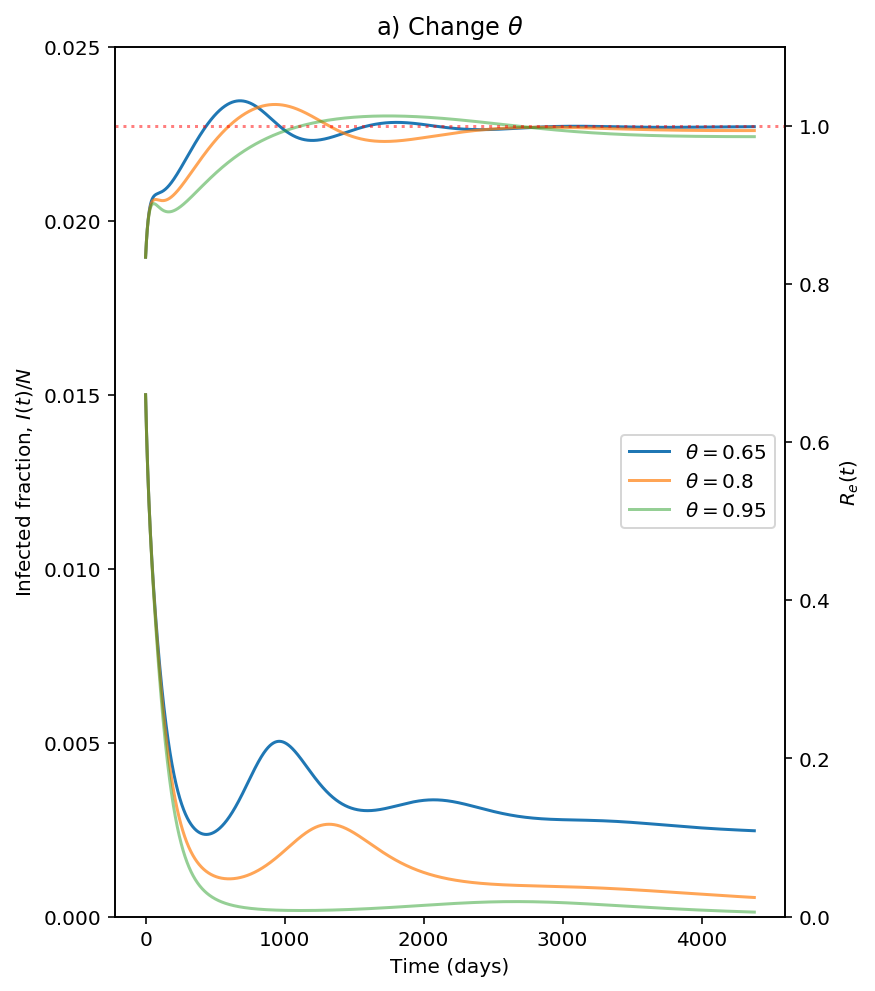

In [66]:
# Change Theta
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_111[:, 2]/N, label=r"$\theta=0.65$")
ax.plot(t1, sol_211[:, 2]/N,alpha=0.7, label=r"$\theta=0.8$")
ax.plot(t1, sol_311[:, 2]/N,alpha=0.5, label=r"$\theta=0.95$")
ax.set_ylim([0,0.025])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_111)
ax2.plot(t1, Re_211, alpha=0.7)
ax2.plot(t1, Re_311, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([0,1.1])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"a) Change $\theta$")

plt.show()


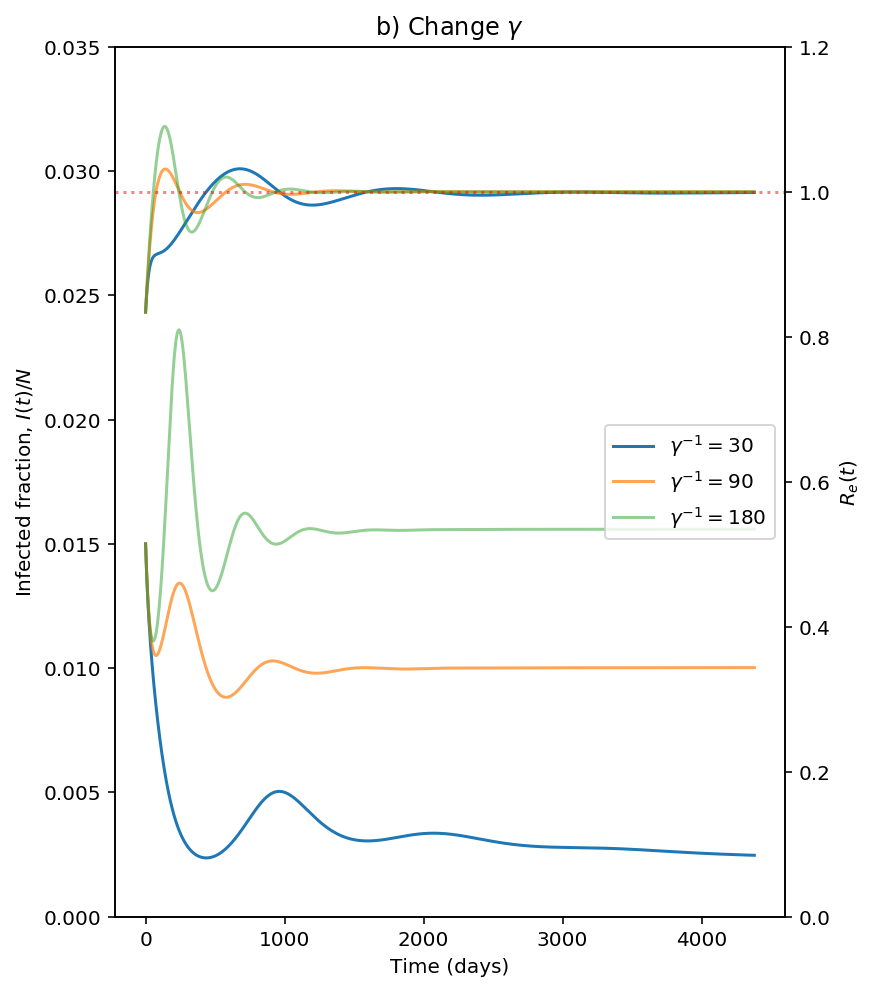

In [67]:
### Change gamma
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_111[:, 2]/N, label=r"$\gamma^{-1}=30$")
ax.plot(t1, sol_112[:, 2]/N,alpha=0.7, label=r"$\gamma^{-1}=90$")
ax.plot(t1, sol_113[:, 2]/N,alpha=0.5, label=r"$\gamma^{-1}=180$")
ax.set_ylim([0,0.035])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_111)
ax2.plot(t1, Re_112, alpha=0.7)
ax2.plot(t1, Re_113, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([0,1.2])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"b) Change $\gamma$ ")

plt.show()


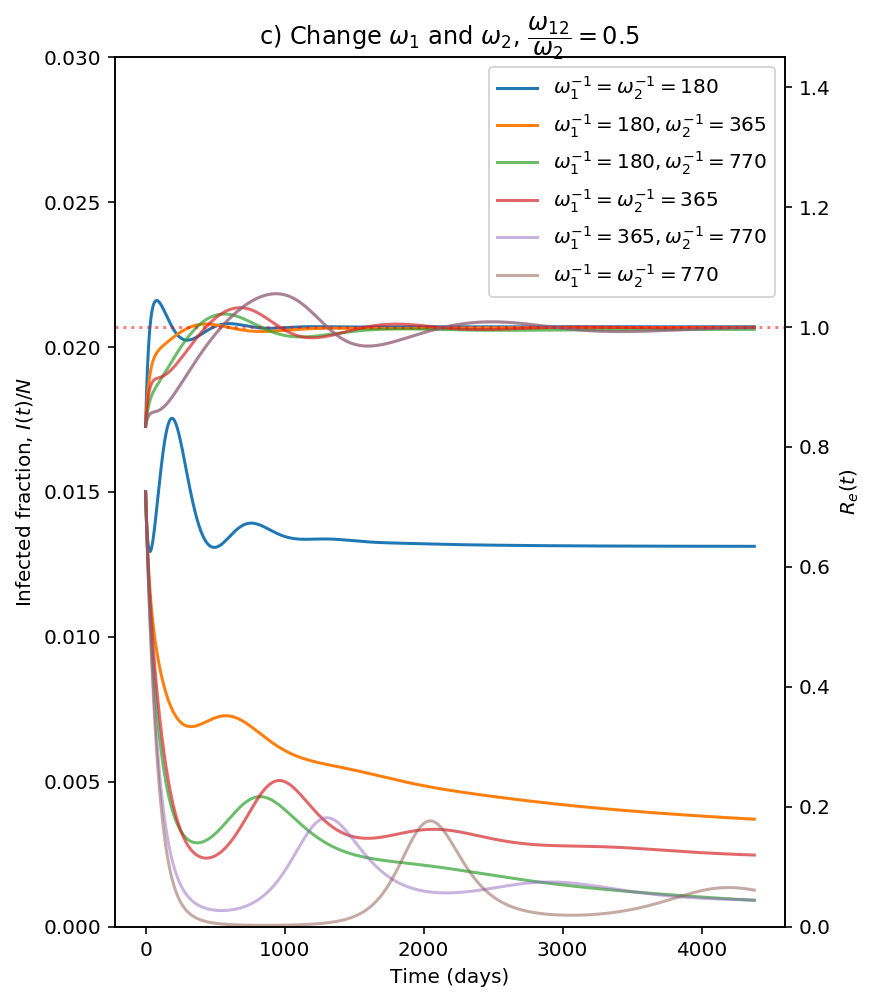

In [73]:
# Change Omega
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_1221[:, 2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
ax.plot(t1, sol_1211[:, 2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
ax.plot(t1, sol_1231[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
ax.plot(t1, sol_111[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
ax.plot(t1, sol_1131[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
ax.plot(t1, sol_1331[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
ax.set_ylim([0,0.03])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend()

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_1221)
ax2.plot(t1, Re_1211)
ax2.plot(t1, Re_1231, alpha=0.7)
ax2.plot(t1, Re_111, alpha=0.7)
ax2.plot(t1, Re_1131, alpha=0.5)
ax2.plot(t1, Re_1331, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([0,1.45])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"c) Change $\omega_{1}$ and $\omega_{2}$, $\dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=12)

plt.show()


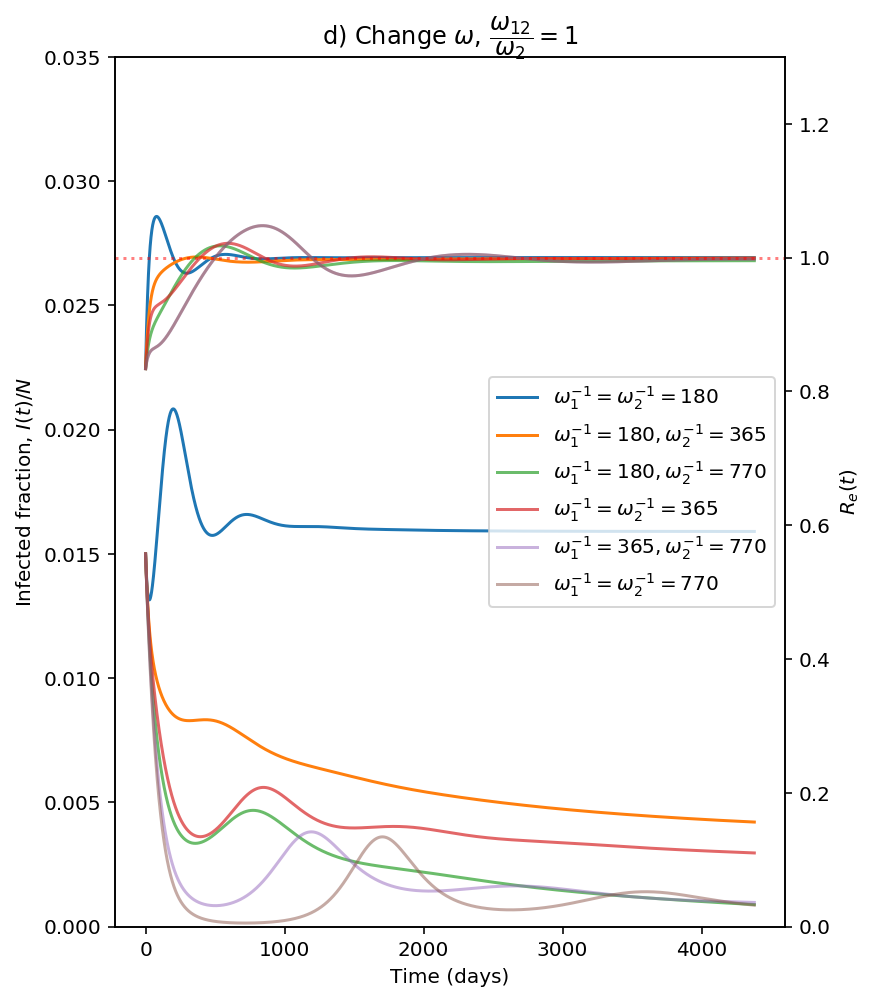

In [76]:
# Change Omega, ratio=1
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(6, 8))
# I(t)
ax.plot(t1, sol_1221_d[:, 2]/N, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
ax.plot(t1, sol_1211_d[:, 2]/N, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
ax.plot(t1, sol_1231_d[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
ax.plot(t1, sol_111_d[:, 2]/N,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
ax.plot(t1, sol_1131_d[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
ax.plot(t1, sol_1331_d[:, 2]/N,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
ax.set_ylim([0,0.035])
ax.set_xlabel("Time (days)")
ax.set_ylabel(r"Infected fraction, $I(t)/N$")
ax.legend(loc=7)

# Re(t)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(t1, Re_1221_d)
ax2.plot(t1, Re_1211_d)
ax2.plot(t1, Re_1231_d, alpha=0.7)
ax2.plot(t1, Re_111_d, alpha=0.7)
ax2.plot(t1, Re_1131_d, alpha=0.5)
ax2.plot(t1, Re_1331_d, alpha=0.5)
ax2.set_ylabel(r"$R_{e}(t)$")
ax2.set_ylim([0,1.3])
plt.axhline(y=1, color="red", alpha=0.5, ls=':')
plt.title(r"d) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=12)

plt.show()


In [78]:
dm_111=get_dm(sol_111)
dm_111_d=get_dm(sol_111_d)
dm_211=get_dm(sol_211)
dm_311=get_dm(sol_311)
dm_1221=get_dm(sol_1221)
dm_1211=get_dm(sol_1211)
dm_1231=get_dm(sol_1231)
dm_1131=get_dm(sol_1131)
dm_1331=get_dm(sol_1331)

dm_1221_d=get_dm(sol_1221_d)
dm_1211_d=get_dm(sol_1211_d)
dm_1231_d=get_dm(sol_1231_d)
dm_1131_d=get_dm(sol_1131_d)
dm_1331_d=get_dm(sol_1331_d)
dm_112=get_dm(sol_112)
dm_113=get_dm(sol_113)

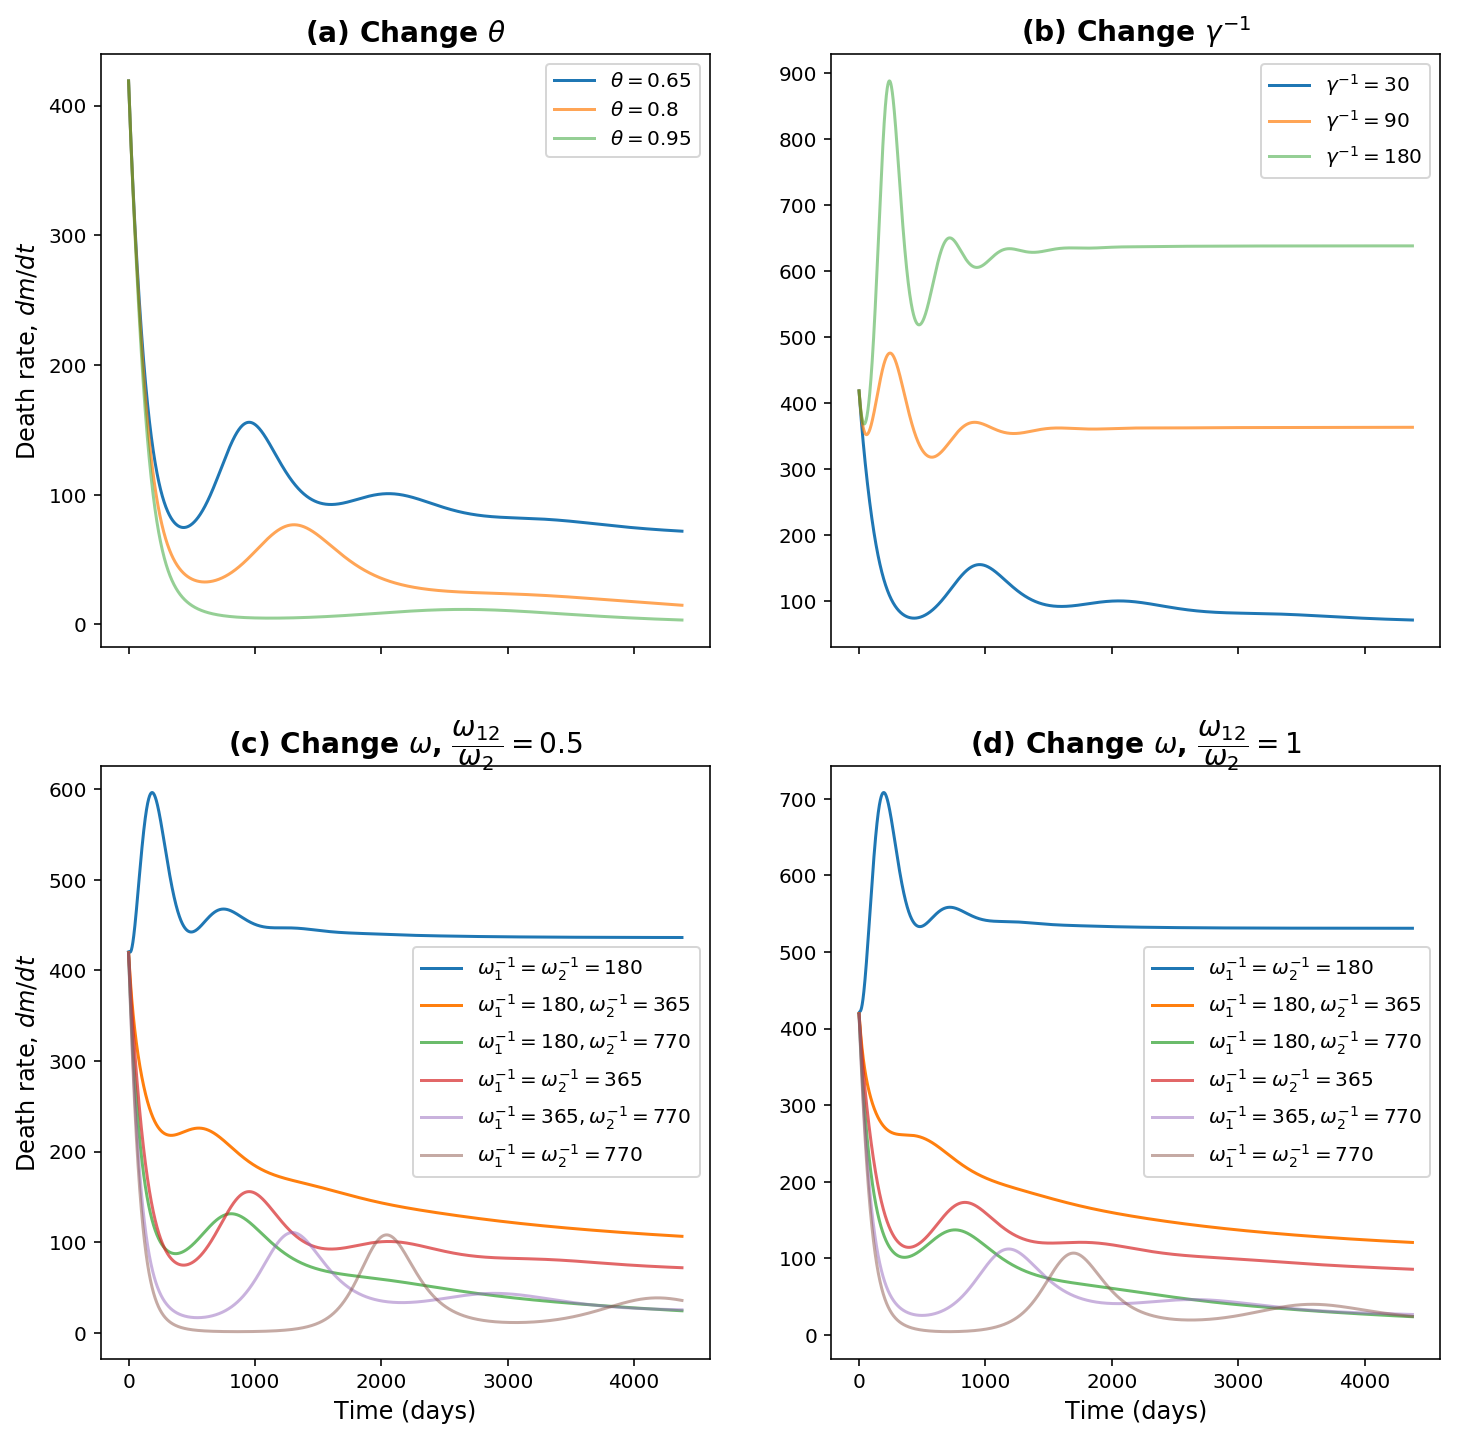

In [80]:
fig, axes = plt.subplots(2, 2,figsize=(12, 12),
                       sharex='col')
axes[0, 0].plot(dm_111, label=r"$\theta=0.65$")
axes[0, 0].plot(dm_211, alpha=0.7, label=r"$\theta=0.8$")
axes[0, 0].plot(dm_311, alpha=0.5, label=r"$\theta=0.95$")
axes[0, 0].set_ylabel(r"Death rate, $dm/dt$", fontsize=12)
axes[0, 0].set_title(r"(a) Change $\theta$", fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].plot(dm_111, label=r"$\gamma^{-1}=30$")
axes[0, 1].plot(dm_112,  alpha=0.7,label=r"$\gamma^{-1}=90$")
axes[0, 1].plot(dm_113,  alpha=0.5,label=r"$\gamma^{-1}=180$")
axes[0, 1].set_title(r"(b) Change $\gamma^{-1}$", fontsize=14, fontweight='bold')
axes[0, 1].legend()


axes[1, 0].plot(dm_1221, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[1, 0].plot(dm_1211, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[1, 0].plot(dm_1231,alpha=0.7, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[1, 0].plot(dm_111,alpha=0.7, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[1, 0].plot(dm_1131,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
axes[1, 0].plot(dm_1331,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")
axes[1, 0].set_ylabel(r"Death rate, $dm/dt$", fontsize=12)
axes[1, 0].set_xlabel("Time (days)", fontsize=12)
axes[1, 0].set_title(r"(c) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=0.5$", fontsize=14, fontweight='bold')
axes[1, 0].legend()


axes[1, 1].plot(dm_1221_d, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=180$")
axes[1, 1].plot(dm_1211_d, label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=365$")
axes[1, 1].plot(dm_1231_d, alpha=0.7,label=r"$\omega_{1}^{-1}=180, \omega_{2}^{-1}=770$")
axes[1, 1].plot(dm_111_d, alpha=0.7,label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=365$")
axes[1, 1].plot(dm_1131_d,alpha=0.5, label=r"$\omega_{1}^{-1}=365,  \omega_{2}^{-1}=770$")
axes[1, 1].plot(dm_1331_d,alpha=0.5, label=r"$\omega_{1}^{-1}=\omega_{2}^{-1}=770$")

axes[1, 1].set_xlabel("Time (days)", fontsize=12)
axes[1, 1].set_title(r"(d) Change $\omega$, $\dfrac{\omega_{12}}{\omega_{2}}=1$", fontsize=14, fontweight='bold')
axes[1, 1].legend()

#fig.suptitle('Death rate for different parameters', fontsize=16, fontweight='bold')
plt.show()